In [3]:

import cv2
import numpy as np
from sklearn.cluster import KMeans


def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(15, 15))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

def show_point(image, x_point, y_point, color = (0, 255, 255), reversed=True):
    image_temp = image.copy()
    for (x, y) in zip(x_point, y_point):
        if reversed: cv2.circle(image_temp, (int(x), int(image.shape[1] - y)), 4, color, -1)
        else: cv2.circle(image_temp, (int(x), int(y)), 4, color, -1)
    show_img(image_temp)

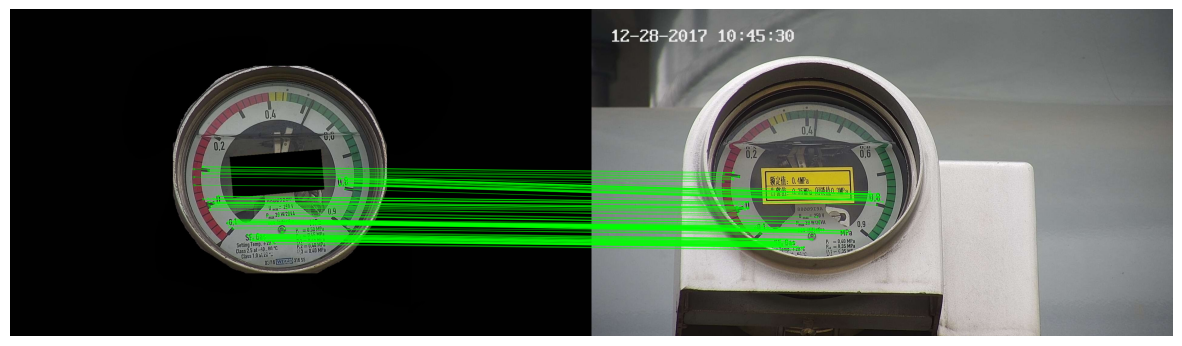

In [10]:
import cv2
import numpy as np

# 1. 加载图像
img1 = cv2.imread('../source/template2.jpg')  # 查询图像
img2 = cv2.imread('../source/1.2/tv201712281045269FF0WY.jpg')  # 训练图像

# 2. 创建 AKAZE 特征检测器
akaze = cv2.AKAZE_create()

# 3. 检测关键点和描述符
kp1, des1 = akaze.detectAndCompute(img1, None)
kp2, des2 = akaze.detectAndCompute(img2, None)

# 4. 使用网格采样方法，选择特征点
def grid_sampling(kp, img, grid_size=(10, 10)):
    h, w = img.shape[:2]
    # 将图像分为若干个网格
    grid_height, grid_width = grid_size
    grid_kps = []

    for y in range(0, h, h // grid_height):
        for x in range(0, w, w // grid_width):
            # 在每个网格区域中选择最靠近网格中心的特征点
            best_kp = None
            min_dist = float('inf')
            for k in kp:
                px, py = k.pt
                if x <= px < x + w // grid_width and y <= py < y + h // grid_height:
                    dist = np.sqrt((px - (x + w // grid_width // 2))**2 + (py - (y + h // grid_height // 2))**2)
                    if dist < min_dist:
                        best_kp = k
                        min_dist = dist
            if best_kp:
                grid_kps.append(best_kp)

    return grid_kps

# 对图2进行网格采样
grid_kp2 = grid_sampling(kp2, img2, grid_size=(10, 10))

# 5. 使用暴力匹配器（BFMatcher）进行匹配
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# 6. 按照距离排序匹配结果
matches = sorted(matches, key=lambda x: x.distance)

# 7. 提取匹配点的坐标
pts1 = np.array([kp1[m.queryIdx].pt for m in matches])
pts2 = np.array([kp2[m.trainIdx].pt for m in matches])

# 8. 计算单应性矩阵
H, status = cv2.findHomography(pts1, pts2, cv2.RANSAC)

# 9. 创建绘制参数，绿色为内点，灰色为外点
matches_mask = [0] * len(matches)
for i in range(len(matches)):
    if status[i] == 1:
        matches_mask[i] = 1  # 内点标记为1

draw_params = dict(matchColor=(0, 255, 0),  # 绿色表示内点
                   singlePointColor=(255, 0, 0),  # 蓝色表示未匹配的点（可选）
                   matchesMask=matches_mask,  # 使用mask过滤掉外点
                   flags=2)

# 10. 绘制匹配结果
img_matches = cv2.drawMatches(
    img1, kp1, img2, kp2, matches, None, **draw_params)

show_img(img_matches)